# Marketing and business strategy

**Objective**  
Analyze the market and optimize them strategies to attract more clients.

**Objective Sprint 3**  
WHICH CITIES AND NEIGHBORHOODS HAVE THE GREATEST OPTIMIZATION POTENTIAL

### Libraries

In [21]:
# import libraries 
import os
import re
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy

from dotenv import load_dotenv, find_dotenv
from download_data import get_latest_table
from sqlalchemy import create_engine

## Load environment variables

In [22]:
# load environment variables
dotenv_path = find_dotenv()
if dotenv_path:
    load_dotenv(dotenv_path)
else:
    print(".env file not found")

# environment variables because we need connect to mysql
CONFIG = {
    'user': os.getenv('MYSQL_USER'),
    'password': os.getenv('MYSQL_PASSWORD'),
    'host': os.getenv('HOST'),
    'database': 'Equip_F',
    'raise_on_warnings': True
}

### Connection to MySQL

In [23]:
import mysql.connector
from mysql.connector import Error

try:
    # Establish connection to MySQL
    connection = mysql.connector.connect(**CONFIG)
    
    if connection.is_connected():
        db_info = connection.get_server_info()
        print(f"Conexión exitosa a MySQL Server versión {db_info}")
        cursor = connection.cursor()
        cursor.execute("SELECT DATABASE();")
        record = cursor.fetchone()
        print(f"Conectado a la base de datos: {record[0]}")

except Error as e:
    print(f"Error al conectar a MySQL: {e}")

Conexión exitosa a MySQL Server versión 8.0.41-0ubuntu0.24.04.1
Conectado a la base de datos: Equip_F


## Overview data

## Business Question 3
### WHICH CITIES AND NEIGHBORHOODS HAVE THE GREATEST OPTIMIZATION POTENTIAL

In [24]:
df = pd.read_sql("""SELECT * FROM ST1_Tourist_Accommodation_07042025""", connection)
df.shape
df.info()

C:\Users\admin\AppData\Local\Temp\ipykernel_20048\460559249.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""SELECT * FROM ST1_Tourist_Accommodation_07042025""", connection)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9650 entries, 0 to 9649
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 9650 non-null   int64         
 1   name                         9647 non-null   object        
 2   description                  9516 non-null   object        
 3   host_id                      9650 non-null   int64         
 4   neighbourhood_name           9650 non-null   object        
 5   neighbourhood_district       5860 non-null   object        
 6   room_type                    9650 non-null   object        
 7   accommodates                 9650 non-null   int64         
 8   bathrooms                    9578 non-null   float64       
 9   bedrooms                     9580 non-null   float64       
 10  beds                         9605 non-null   float64       
 11  amenities_list               9634 non-null 

## Cálculo de formula
### Pondera las variables escogidas como claves para el cálculo de ciudades y barrios con potencial

### Minimum_nights

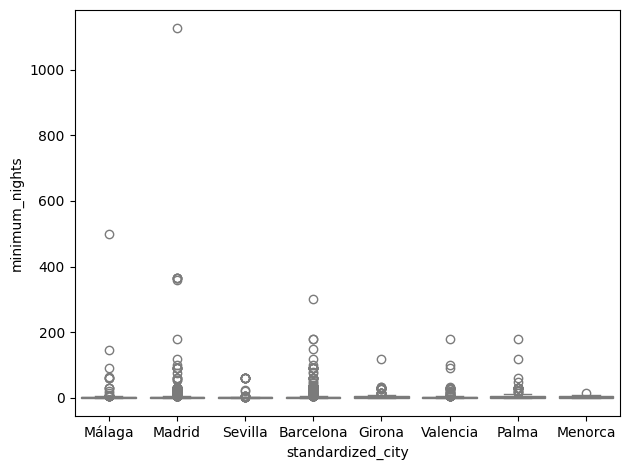

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=df, x='standardized_city', y='minimum_nights')


plt.tight_layout()
plt.show()


### Maximum_nights

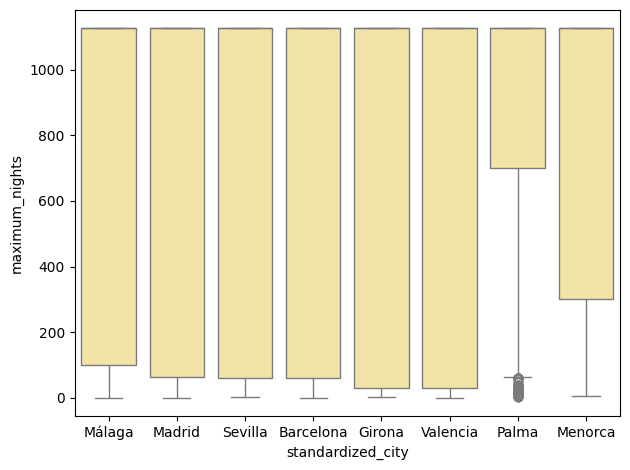

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=df, x='standardized_city', y='maximum_nights')

plt.tight_layout()
plt.show()


### Review Score Location

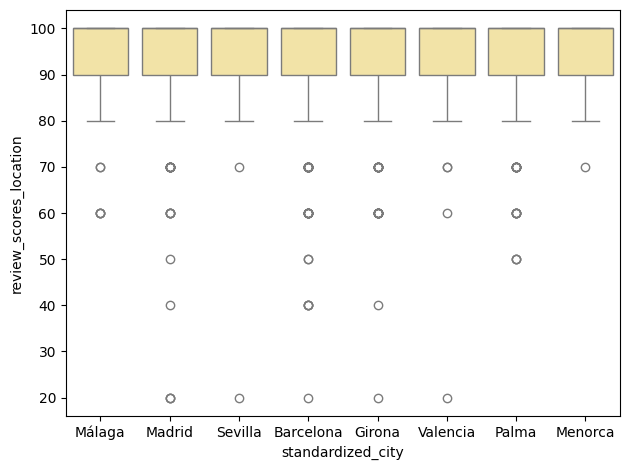

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=df, x='standardized_city', y='review_scores_location')

plt.tight_layout()
plt.show()


### Review Score Rating

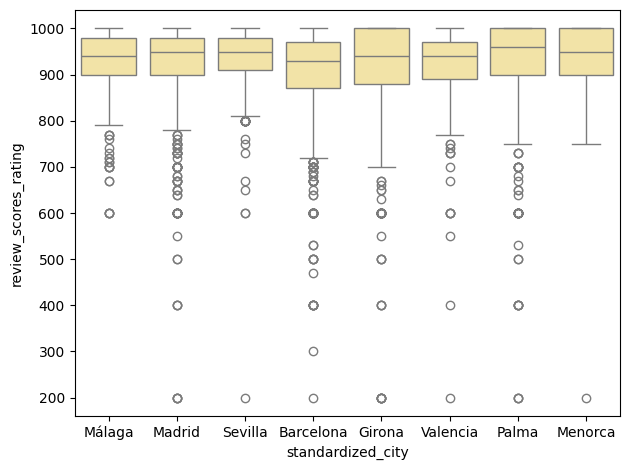

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=df, x='standardized_city', y='review_scores_rating')

plt.tight_layout()
plt.show()

## Principal Formula

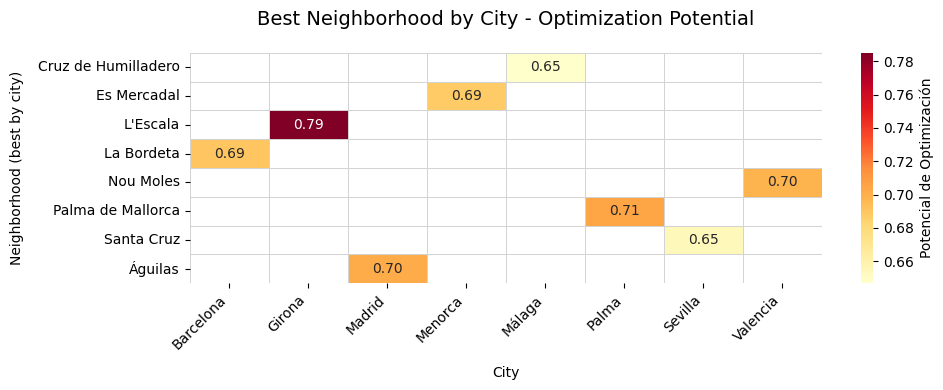

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo para los gráficos

sns.set_palette("YlOrRd")

def main():
 

    # Conversión de columnas a numéricas
    df['review_scores_location'] = pd.to_numeric(df['review_scores_location'], errors='coerce')
    df['review_scores_rating'] = pd.to_numeric(df['review_scores_rating'], errors='coerce')
    df['minimum_nights'] = pd.to_numeric(df['minimum_nights'], errors='coerce')
    df['maximum_nights'] = pd.to_numeric(df['maximum_nights'], errors='coerce')

    # Filtrar registros válidos
    df_filtered = df[
        df['review_scores_location'].notnull() &
        df['review_scores_rating'].notnull() &
        df['minimum_nights'].notnull() &
        df['maximum_nights'].notnull()
    ].copy()

    # Quitar outliers: valores extremos en minimum y maximum nights
    df_filtered = df_filtered[df_filtered['minimum_nights'] <= 365]
    df_filtered = df_filtered[df_filtered['maximum_nights'] <= 365]

    # Quitar barrios con comas en el nombre
    df_filtered = df_filtered[~df_filtered['standardized_neighbourhood'].str.contains(',', na=False)]

    # Función de normalización segura
    def safe_minmax(series):
        min_val = series.min()
        max_val = series.max()
        range_val = max_val - min_val
        return (series - min_val) / range_val if range_val != 0 else series * 0

    # Normalizar variables
    df_filtered['loc_score_norm'] = safe_minmax(df_filtered['review_scores_location'])
    df_filtered['rating_score_norm'] = safe_minmax(df_filtered['review_scores_rating'])
    df_filtered['min_nights_norm'] = safe_minmax(df_filtered['minimum_nights'])
    df_filtered['max_nights_norm'] = 1 - safe_minmax(df_filtered['maximum_nights'])  # inverso

    # Calcular índice de potencial de optimización
    df_filtered['optim_potential'] = (
        df_filtered['loc_score_norm'] * 0.4 +
        df_filtered['min_nights_norm'] * 0.2 +
        df_filtered['max_nights_norm'] * 0.2 +
        (1 - df_filtered['rating_score_norm']) * 0.2
    )

    # Seleccionar el barrio con mayor potencial de optimización por ciudad
    top_neighbourhoods = df_filtered.sort_values('optim_potential', ascending=False)\
                                   .groupby('standardized_city')\
                                   .head(1)\
                                   .sort_values('standardized_city')

    # Crear tabla pivote para heatmap con solo los barrios seleccionados
    pivot_table = top_neighbourhoods.pivot(
        index='standardized_neighbourhood',
        columns='standardized_city',
        values='optim_potential'
    )

    # Crear heatmap con los resultados filtrados
    plt.figure(figsize=(10, 4))
    ax = sns.heatmap(
        pivot_table,
        annot=True,
        fmt=".2f",
        cmap="YlOrRd",
        linewidths=.5,
        linecolor='lightgray',
        cbar_kws={'label': 'Potencial de Optimización'}
    )

    plt.title("Best Neighborhood by City - Optimization Potential", pad=20, fontsize=14)
    plt.xlabel("City", labelpad=10)
    plt.ylabel("Neighborhood (best by city)", labelpad=10)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)


    # Ajustar layout
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

if __name__ == "__main__":
    main()

### Conclusions

We combined and normalized these factors for each neighborhood and ranked them. Neighborhoods with high location, but strict rules of residence and low ratings, appear to have the greatest optimization potential. This index guides strategic decisions to improve products, commercial policies, or promotions by area.

### Recommendations
1. Implement pilots in key areas with the greatest potential
2. Review minimum stay policies
3. Improve reputation in key areas
4. Train strategic hosts